In [1]:
import numpy as np
import pandas as pd
fpath="/Users/ding/Documents/KBSS/KCWI/kcwi.AGN.QSO.list"
data = []

# Extract columns and data



with open(fpath, 'r') as f:
    for ind,line in enumerate(f):
        if not line.startswith('#'):
            if ind == 0:
                columns = line.strip().split()
            else:
            # Split only by the first 10 delimiters to keep the last column intact
                parts = line.strip().split(maxsplit=11)
                if len(parts) == 12:  # We expect 11 columns in total
                    data.append(parts)

# Convert data into DataFrame
df = pd.DataFrame(data, columns=columns)
print(df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ding/Documents/KBSS/KCWI/kcwi.AGN.QSO.list'

In [ ]:
pd.set_option('display.max_colwidth', None)
print(df["Comments"])

In [ ]:
from astropy.io import fits
from jdaviz import Cubeviz
cpath="/disk/bifrost/yuanze/KBSS/Q1549-BX101/q1549-BX101_icubes_wcs.fits"
hdul = fits.open(cpath)
data_cube = hdul[0].data
header = hdul[0].header
hdul.close()



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18

from specutils.fitting import estimate_line_parameters,fit_lines
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb

from importlib import reload
import pyregion as pyreg
from spectral_cube import SpectralCube

from frb.frb import FRB
from frb.analysis import kcwi


In [3]:
plt.rcParams['font.size'] = 17
flam = r"$F_\lambda$ $\rm (10^{-20}~erg~s^{-1}~cm^{-2}~\AA^{-1}$"
flam2 = r"$\sigma(F_\lambda)^2$ $\rm (10^{-40}~erg^2~s^{-2}~cm^{-4}~\AA^{-2}$"
brighu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax

In [4]:
cubefile = "/disk/bifrost/yuanze/KBSS/Q1549/BX101/q1549-BX101_icubes_wcs.fits"
varfile = "/disk/bifrost/yuanze/KBSS/Q1549/BX101/q1549-BX101_vcubes.fits"

cube = SpectralCube.read(cubefile) 
varcube = SpectralCube.read(varfile)
spat_wcs = cube.wcs.celestial

In [66]:
cube.spectral_axis

<Quantity [3229., 3230., 3231., ..., 5823., 5824., 5825.] Angstrom>

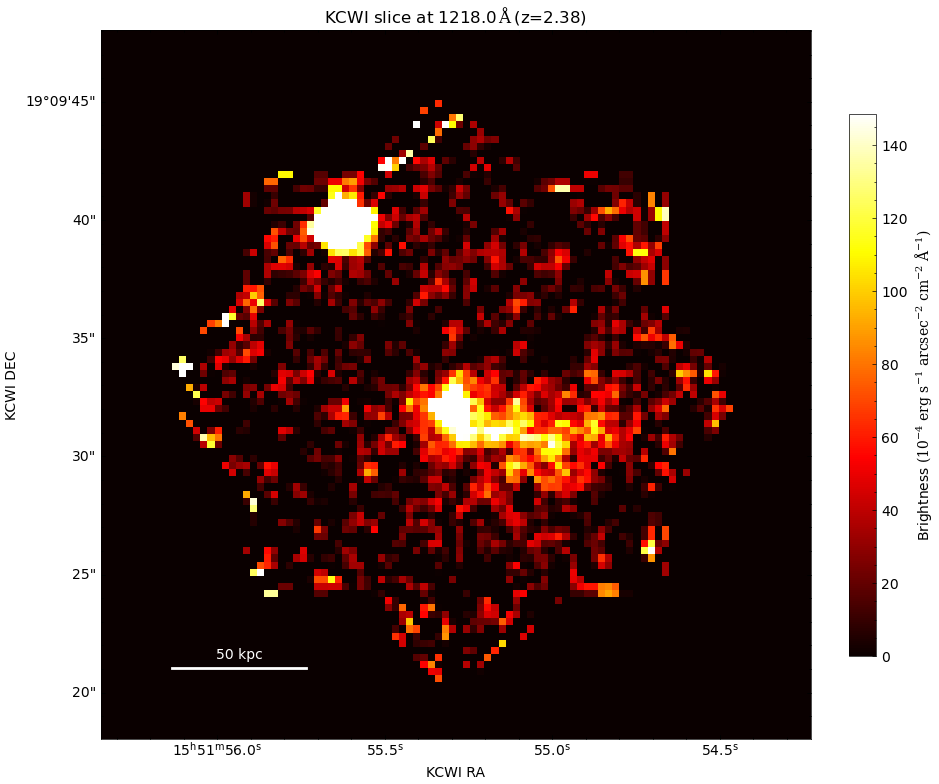

In [6]:
redshift = 2.38  # BX101
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60

rest_wavelength=1218. * u.AA # Ly-alpha line
desired_wavelength = rest_wavelength * (redshift+1)  

# Find the channel index closest to the desired wavelength:
channel_index = (abs(cube.spectral_axis - desired_wavelength)).argmin()
# Spatial slice
testslice = cube[channel_index,:, :]
slicev=testslice.value*1e4
_, med, std = sigma_clipped_stats(slicev)
fig, ax = imshow_astro(slicev, spat_wcs, cblabel = brighu, vrange = (med, med+10*std))

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = spat_wcs.pixel_to_world(start_x, start_y)
end_coord = spat_wcs.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

#length_in_pixels2 = delta_theta_deg2 / delta_ra_per_pixel

#ax.plot([start_x, start_x + length_in_pixels2], [start_y-1, start_y-1], color='white', lw=2)

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='white', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '50 kpc', color='white', ha='center', va='bottom')

ax.set_title(r"KCWI slice at {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))
plt.show()

In [7]:
channel_index

888

In [12]:
img = kcwi.get_img(cubefile)

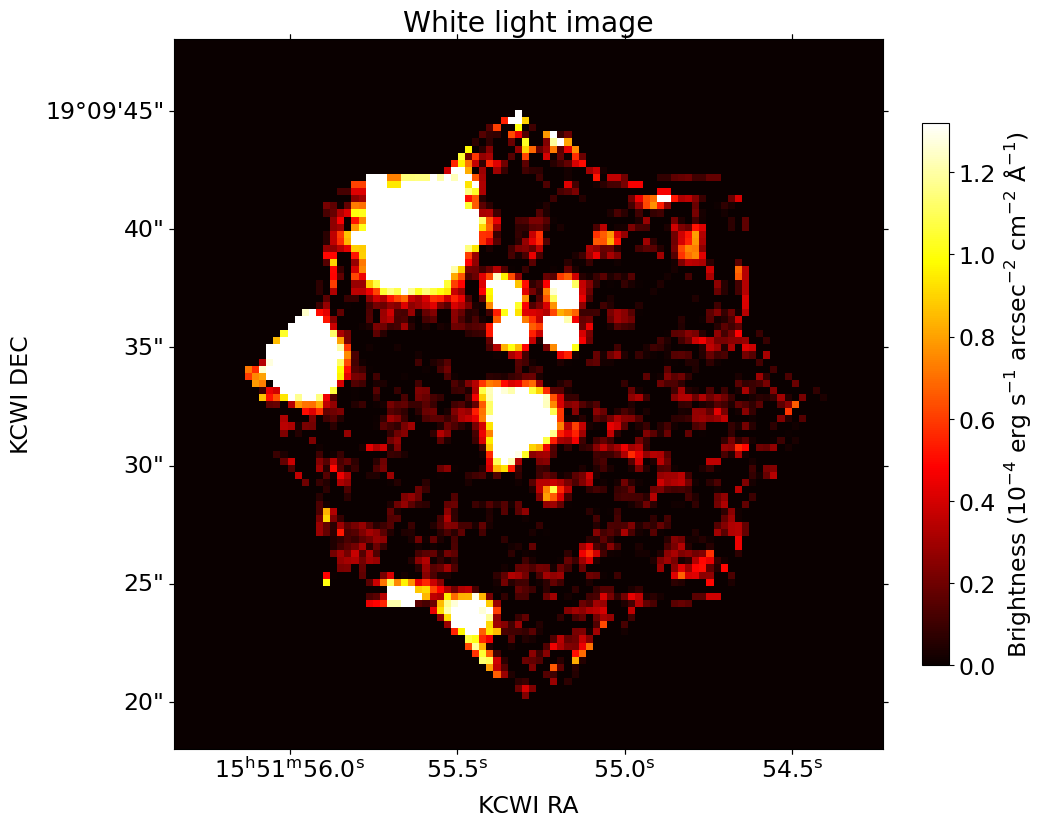

In [9]:
fig, ax = imshow_astro(img.value, img.wcs, cblabel = brighu)
ax.set_title("White light image")
plt.show()

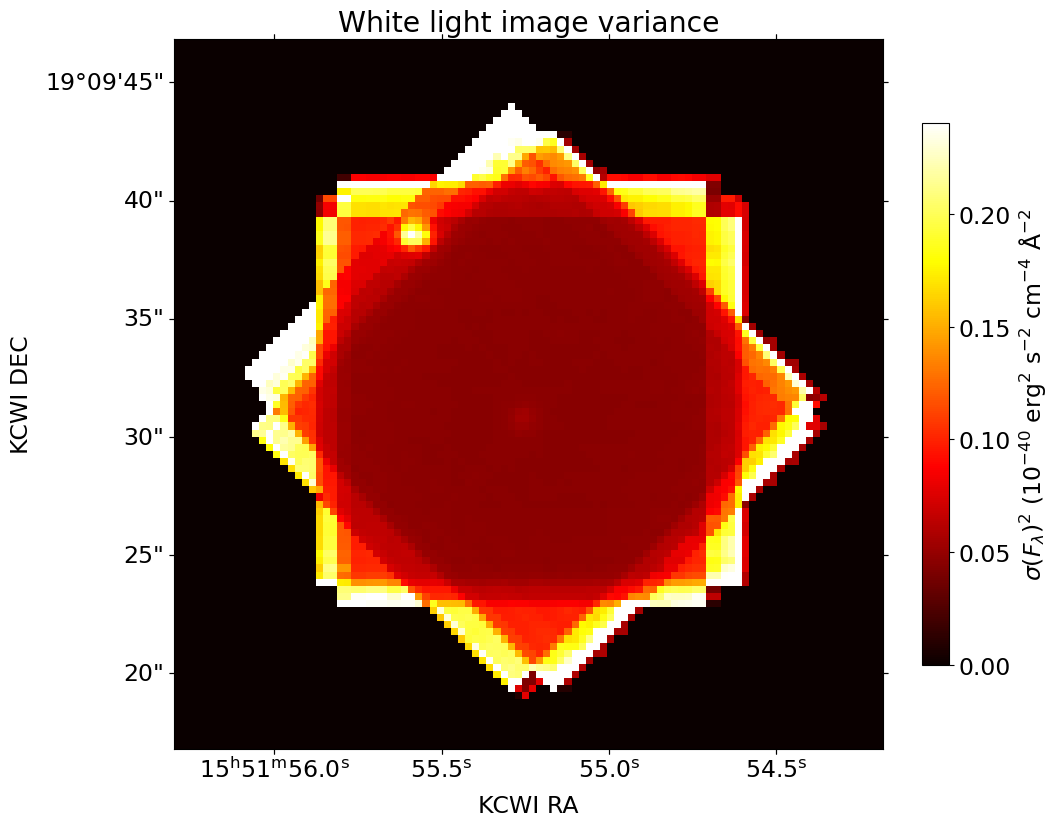

In [10]:
varimg = kcwi.get_img(varfile)
fig, ax = imshow_astro(varimg.value, varimg.wcs, cblabel=flam2)
ax.set_title("White light image variance")
plt.show()

In [13]:
regfile="/disk/bifrost/yuanze/KBSS/Q1549/BX101/reg1.reg"
reg = pyreg.open(regfile).as_imagecoord(img.header)
myfilter=reg.get_filter()
plumask = (myfilter[0] or myfilter[1] or myfilter[2]).mask(img.data)
mask1 = myfilter[0].mask(img.data)
mask2 = myfilter[1].mask(img.data)
mask3 = myfilter[2].mask(img.data)
maskce = myfilter[3].mask(img.data)


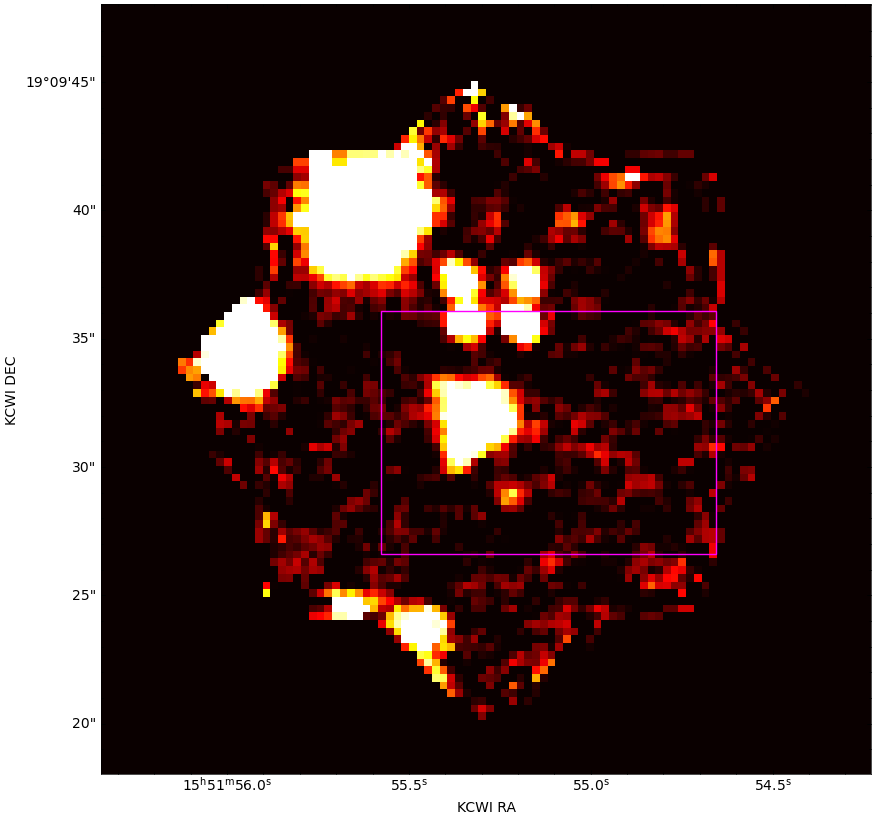

In [14]:
from pyregion.mpl_helper import properties_func_default
#mask_vis = np.where(mask, 1, 0)
fig.clear()
fig, ax = imshow_astro(img.value, img.wcs, colorbar = False)
# Use custom function for patch attribute
def fixed_color(shape, saved_attrs):
    attr_list, attr_dict = saved_attrs
    attr_dict["color"] = "green"
    kwargs = properties_func_default(shape, (attr_list, attr_dict))

    return kwargs
patch_list, artist_list = reg.get_mpl_patches_texts()
ax.add_patch(patch_list[-1])
#for p in patch_list:
    #ax.add_patch(p)
#for t in artist_list:
#    ax.add_artist(t)
plt.show()

In [15]:
spec, varspec = kcwi.spec_from_mask(cube,maskce,varcube, kind = "mean")
sigma=np.sqrt(varspec.data)
x=cube.spectral_axis

/tmp/ipykernel_3318862/98310123.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma=np.sqrt(varspec.data)


In [42]:
#lines={'C III':[1906.,1909.], 'N V':[1238.821,1242.804], 'C IV':[1548.187,1550.772], 'He II':[1640.4], "Si III":[1206.5],
#      "Si IV":[1393.76,1402.77],"Si II":[1260.42],"C II":[1334.53]}
lines={ 'N V':[1238.821,1242.804], 'C IV':[1549], "Si III":[1206.5],"Lya":[1216],"Si IV":[1393.76,1402.77],"Si II":[1260.42],"C II":[1334.53]}

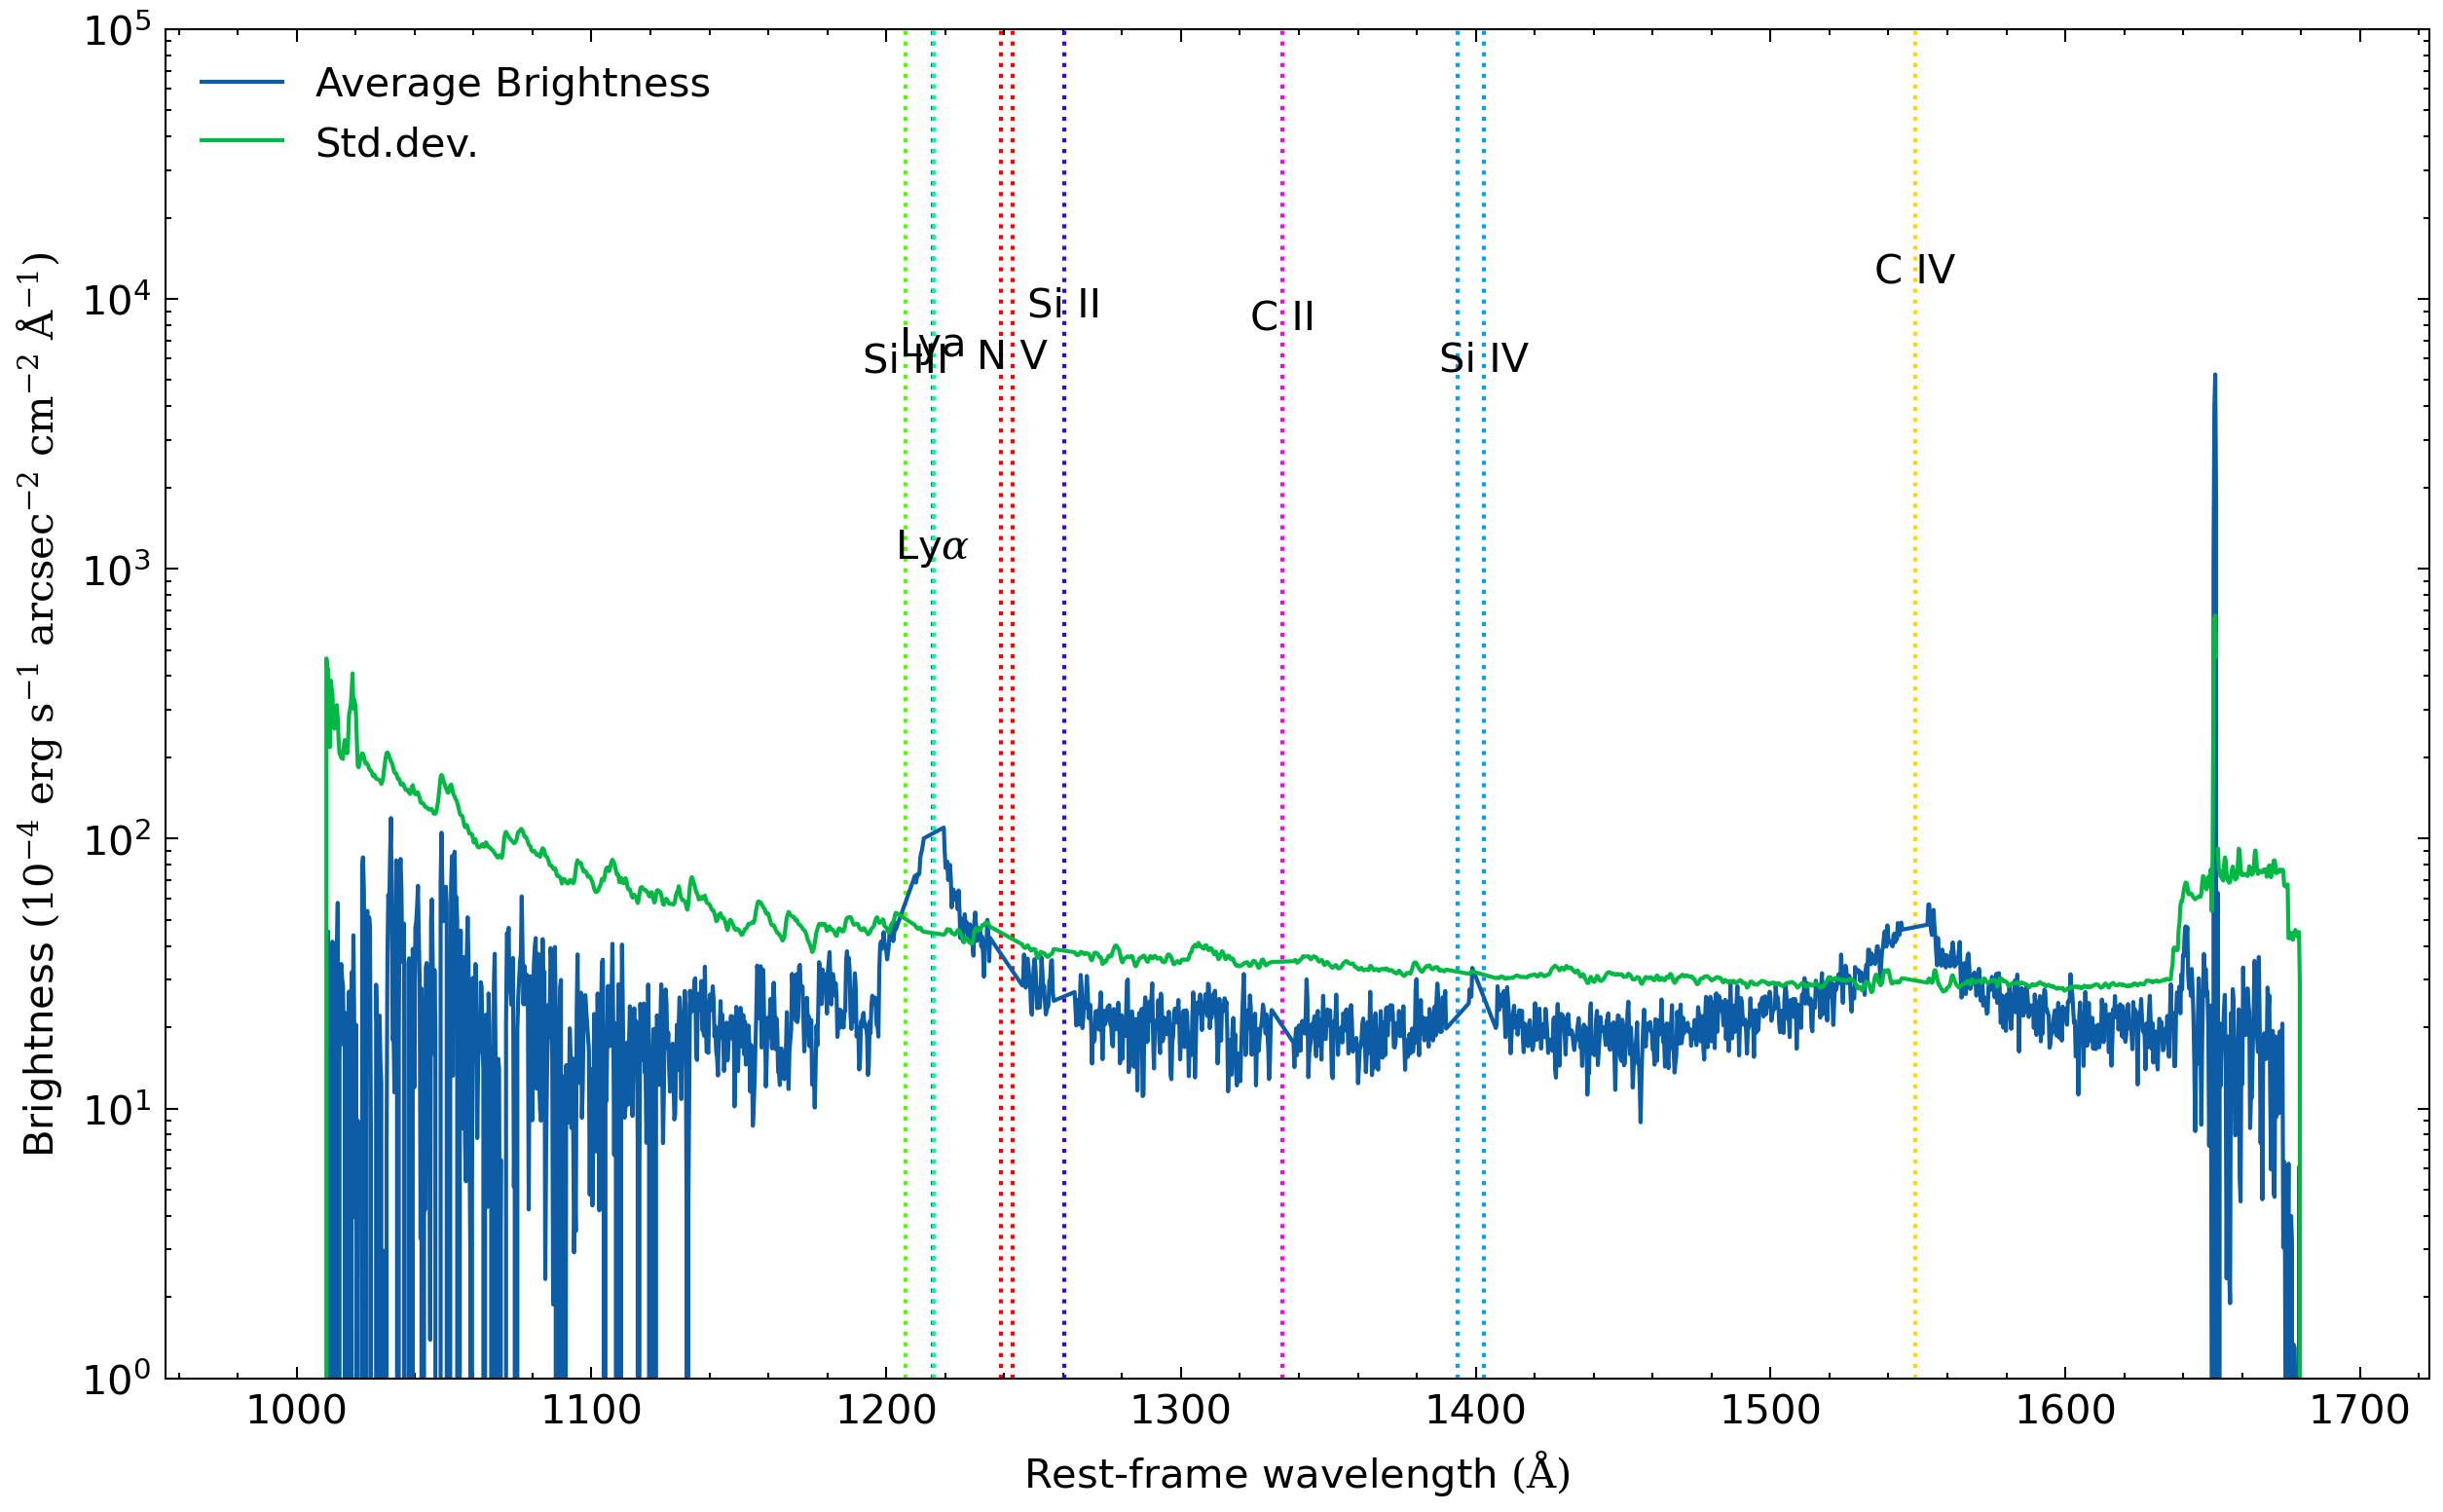

In [61]:
import matplotlib
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
rng1 = np.random.default_rng(122807528840384100672342137672332424406)
fig, ax = plt.subplots(figsize=(10,6),dpi=300)


xlow=cube.spectral_extrema[0].value/(1+redshift)
xhigh=cube.spectral_extrema[1].value/(1+redshift)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))

#Marking the important lines
ax.axvline(1215.67,ls=":")
ax.text(1215.67, 1e3,r"Ly$\alpha$",verticalalignment='bottom',horizontalalignment='center',fontsize=10)
mask=np.full(len(x),False)
dlam=7.5/2800
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c=colors[ind])
            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(line, 5e3+10**(4*rng1.random()),key,verticalalignment='bottom',horizontalalignment='center',fontsize=10)

ax.plot(x[~mask]/(1+redshift), 1e4*spec[~mask], label = "Average Brightness")
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax.plot(x[~mask]/(1+redshift), 1e4*sigma[~mask], label = "Std.dev.")

ax.legend()
ax.set_xlabel(r"Rest-frame wavelength $(\rm \AA)$")
ax.set_ylabel(brighu)
plt.ylim(1, 1e5)
ax.set_xlim([xlow,xhigh])
ax.set_yscale("log")
#fig.savefig("./Q1549-BX101/fig/source_fig.png")

In [24]:
masktmp

array([False, False, False, ..., False, False, False])

(1235.0, 1245.0)

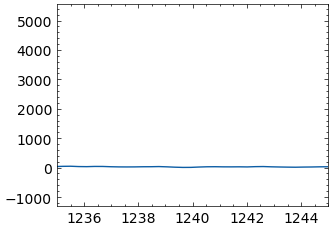

In [18]:
plt.plot(x/(1+redshift), 1e4*spec, label = "Average Brightness")
plt.xlim([1235,1245])

In [ ]:
#Line finding with specutils
from astropy.modeling import models
from specutils.fitting import find_lines_threshold
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty

uncertainty = StdDevUncertainty(np.sqrt(varspec))
spectrum=Spectrum1D(flux=spec, spectral_axis=x/(1+redshift),uncertainty=uncertainty)
flines = find_lines_threshold(spectrum, noise_factor=2) 




In [ ]:
print(flines)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             amplitude                 mean              stddev     
    1e-08 erg / (arcsec2 cm3 s)      Angstrom           Angstrom    
    --------------------------- ------------------ -----------------
            0.02314855940132165 1216.5138596030129 4.811448277266463


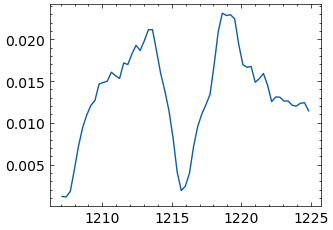

In [99]:


sub_region = SpectralRegion(1207*u.AA, 1225*u.AA)
sub_spectrum = extract_region(spectrum, sub_region)
plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux) 
#model=models.Gaussian1D(amplitude=[1e-2,1e-2,1e-2,1e-2,1e-2], mean=[1200, 1213,1216,1218,1240],stddev=[1, 1,1,1,1], n_models=5)
print(estimate_line_parameters(sub_spectrum,  models.Gaussian1D()))


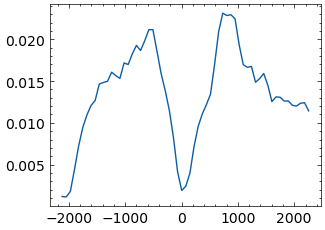

In [100]:
#Getting spectrum centered at Lya
from astropy import constants

c = constants.c.to('km/s')  # Speed of light
rest_wavelength = 1215.67*u.AA  # Replace with the rest wavelength of the line you're interested in, e.g., 6563.0 * u.Angstrom for H-alpha
# Calculate the Doppler shift
velocity = c * ((sub_spectrum.spectral_axis / rest_wavelength) ** 2 - 1) / ((sub_spectrum.spectral_axis / rest_wavelength) ** 2 + 1)

velocity_spectrum = Spectrum1D(spectral_axis=velocity, flux=sub_spectrum.flux)
plt.plot(velocity_spectrum.spectral_axis, velocity_spectrum.flux) 

In [69]:
print(np.median(spec))

0.004096630464338968 1e-08 erg / (arcsec2 cm3 s)


In [96]:
##Single line fitting

g=[]
gtot=models.Gaussian1D(amplitude=1e-2*spec.unit, mean=1214.67*u.AA, stddev=1.*u.AA)+models.Gaussian1D(amplitude=1e-2*spec.unit, mean=1217.67*u.AA, stddev=1.*u.AA)
gtot+=models.PowerLaw1D(amplitude=1e-2*spec.unit,x_0=1200*u.AA,alpha=-0.5)
#for ind,key in enumerate(keys):
#    for line in lines[key]:
#        if line < xhigh and line > xlow:
#            g.append(models.Gaussian1D(amplitude=1e-2*spec.unit, mean=line*u.AA, stddev=1.*u.AA))
#            gtot+=g[-1]

g_fit = fit_lines(spectrum, gtot)
y_fit = g_fit(spectrum.spectral_axis)


/disk/bifrost/yuanze/anaconda3/lib/python3.9/site-packages/astropy/modeling/powerlaws.py:56: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.

In [88]:
print(g_fit[1])

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=0.00477257 1e-08 erg / (arcsec2 cm3 s), mean=1208.84810083 Angstrom, stddev=0. Angstrom)>

    [1]: <Gaussian1D(amplitude=0.01059062 1e-08 erg / (arcsec2 cm3 s), mean=1218.02861554 Angstrom, stddev=11.82302171 Angstrom)>

    [2]: <PowerLaw1D(amplitude=0.10378093 1e-08 erg / (arcsec2 cm3 s), x_0=15653.35575711 Angstrom, alpha=-1.31597179)>
Parameters:
            amplitude_0               mean_0       ...       alpha_2      
    1e-08 erg / (arcsec2 cm3 s)      Angstrom      ...                    
    --------------------------- ------------------ ... -------------------
            0.00477257464595951 1208.8481008289425 ... -1.3159717901565489


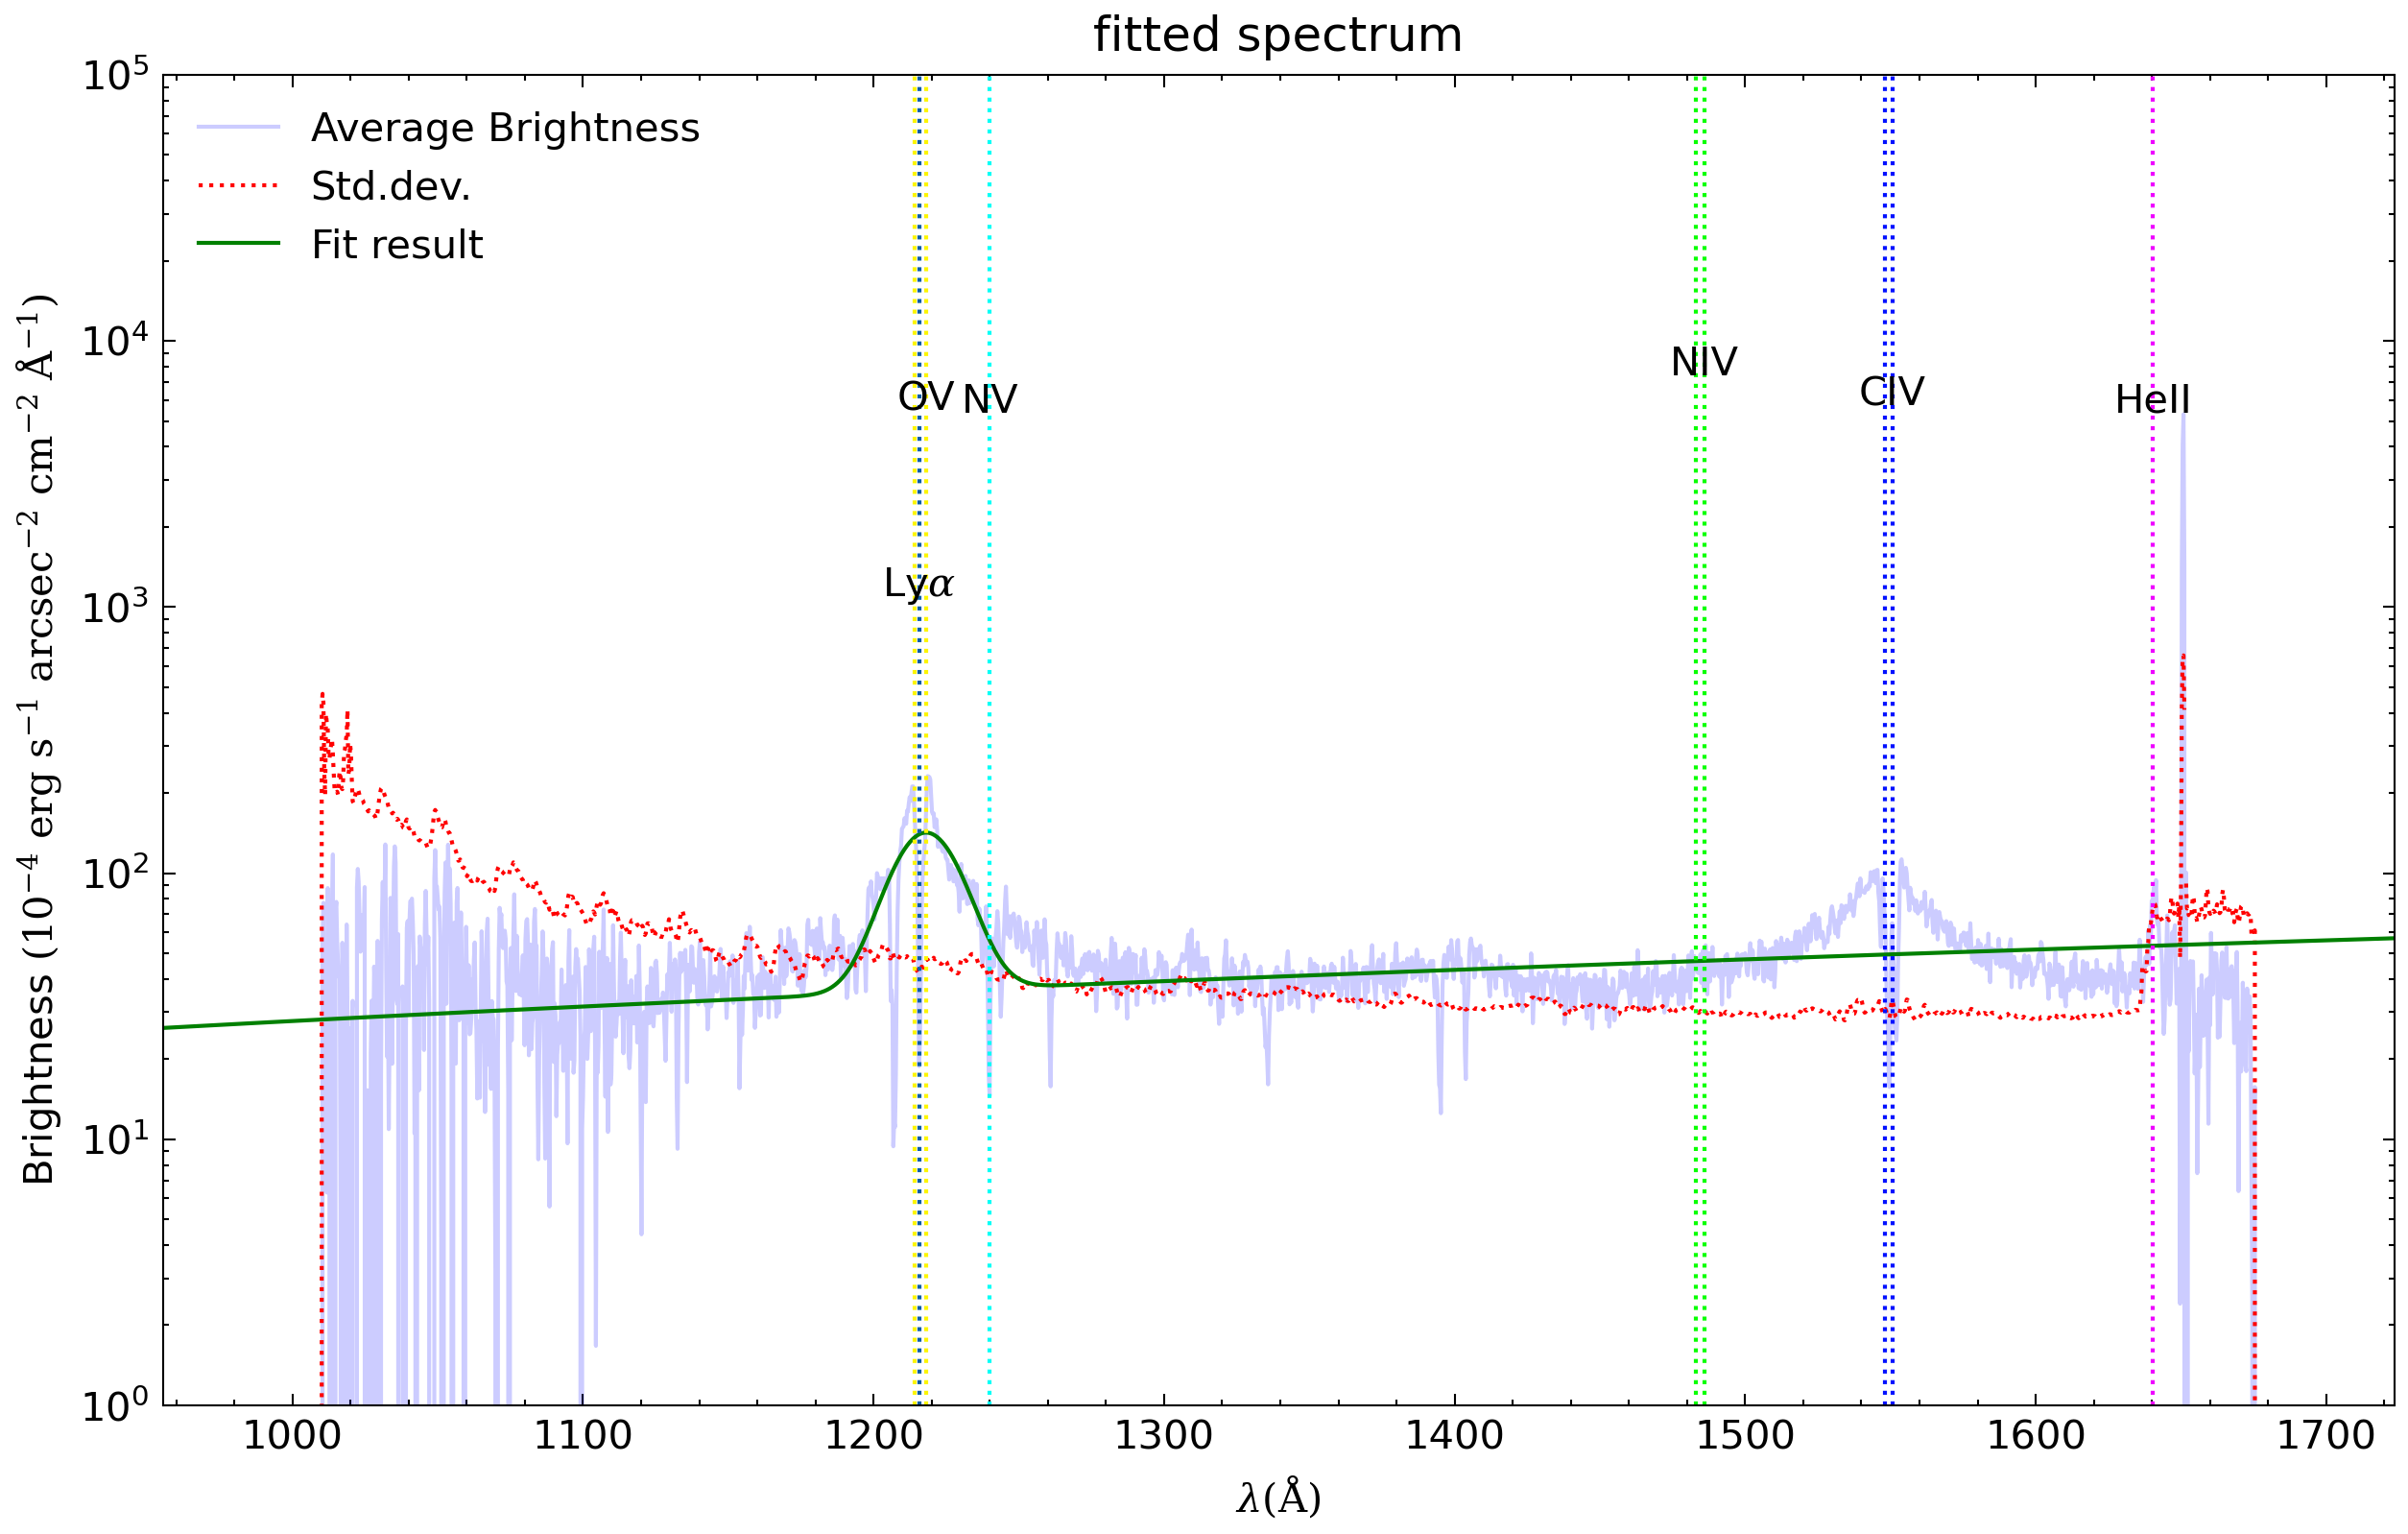

In [86]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
rng1 = np.random.default_rng(122807528840384100672342137672332424406)
fig, ax = plt.subplots(figsize=(10,6),dpi=300)

ax.plot(x/(1+redshift), 1e4*spec, "b", label = "Average Brightness",alpha=0.2)
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax.plot(x/(1+redshift), 1e4*sigma, "r:", label = "Std.dev.")

ax.plot(spectrum.spectral_axis, 1e4*y_fit, "g", label="Fit result")


xlow=cube.spectral_extrema[0].value/(1+redshift)
xhigh=cube.spectral_extrema[1].value/(1+redshift)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))

#Marking the important lines
ax.axvline(1215.67,ls=":")
ax.text(1215.67, 1e3,r"Ly$\alpha$",verticalalignment='bottom',horizontalalignment='center',fontsize=10)
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c=colors[ind])
    if line < xhigh and line > xlow:
        ax.text(line, 5e3+10**(3.5*rng1.random()),key,verticalalignment='bottom',horizontalalignment='center',fontsize=10)
plt.title('fitted spectrum')

ax.legend()
ax.set_xlabel(r"$\lambda (\rm \AA)$")
ax.set_ylabel(brighu)
plt.ylim(1, 1e5)
ax.set_xlim([xlow,xhigh])
ax.set_yscale("log")
fig.savefig("./Q1549-BX101/fig/fitted_fig.png")





In [62]:
S=np.pi*(1.8*u.arcsec)**2*1e-8
factor=S/(u.AA/u.cm*u.cm.to(u.AA))
np.savetxt("Q1549/BX101/BX101_KCWI_cen_spec.txt",np.array([x[~mask],spec[~mask]*S/(u.AA/u.cm*u.cm.to(u.AA)),sigma[~mask]*S/(u.AA/u.cm*u.cm.to(u.AA))]).T)


In [68]:
S=(0.3*u.arcsec)**2*1e-8
factor=S/(u.AA/u.cm*u.cm.to(u.AA))
print(factor)

9.000000000000001e-18 arcsec2 cm / Angstrom


In [15]:
from astropy.cosmology import Planck18
brighu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"

def wcs_transform(w, scale):
    def transform(x, y):
        ra, dec = w.all_pix2world(x, y, 0)
        return ra * scale, dec * scale
    return transform



def imshow_ifu(img, wcsinfo, redshift=0. , figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    scale_kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(redshift).value / 60.0
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 6*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, origin='lower', norm = norm, cmap = cmap)
    # Determine pixel scales in arcseconds
    pix_scale_ra = wcsinfo.pixel_scale_matrix[0,0] * 3600.0  # RA scale in arcsec/pixel
    pix_scale_dec = wcsinfo.pixel_scale_matrix[1,1] * 3600.0  # Dec scale in arcsec/pixel

    # Convert to physical scales
    #pix_scale_ra_kpc = pix_scale_ra * scale_kpc_per_arcsec
    #pix_scale_dec_kpc = pix_scale_dec * scale_kpc_per_arcsec
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    x = np.linspace(0, img.shape[1], 7)
    y = np.linspace(0, img.shape[0], 7)
#    x_labels_kpc = x * pix_scale_ra_kpc
#    y_labels_kpc = y * pix_scale_dec_kpc
    x_labels_arcsec = x * pix_scale_ra
    y_labels_arcsec = y * pix_scale_dec
    # Setting direction arrows
    x0, y0 = 85, 85
    arrow_length = 10

    # North arrow goes upward in y-direction (positive Dec)
    ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
    ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
    ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

#    print(ra,dec)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(np.rint(x_labels_arcsec-np.mean(x_labels_arcsec)).astype(int))
    ax.set_yticklabels(np.rint(y_labels_arcsec-np.mean(y_labels_arcsec)).astype(int))
    ax.set_xlabel("Position (arcsec)")
    ax.set_ylabel("Position (arcsec)")
    return fig, ax

In [16]:
start_coord.ra.degree

NameError: name 'start_coord' is not defined

Text(0.5, 1.0, 'KCWI slice at 1218.0$\\rm\\,\\AA\\,$(z=2.38)')

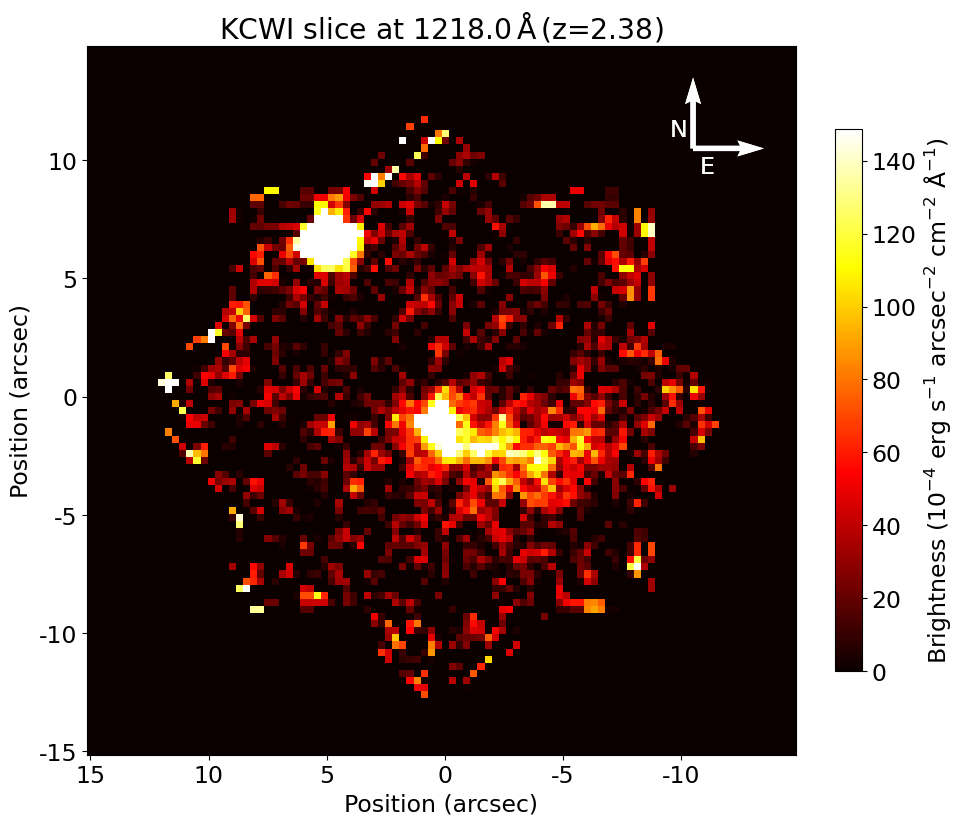

In [17]:
redshift=2.38
rest_wavelength=1218. * u.AA # Ly-alpha line
desired_wavelength = rest_wavelength * (redshift+1)  

# Find the channel index closest to the desired wavelength:
channel_index = (abs(cube.spectral_axis - desired_wavelength)).argmin()
# Spatial slice
testslice = cube[channel_index,:, :]
slicev=testslice.value*1e4
_, med, std = sigma_clipped_stats(slicev)
plt.rcParams['font.size'] = 17

fig, ax = imshow_ifu(slicev, redshift=redshift, wcsinfo=spat_wcs, cblabel = brighu, vrange = (med, med+10*std))
x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')

# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')
ax.set_title(r"KCWI slice at {}$\rm\,\AA\,$(z={})".format(round(rest_wavelength.value,1),round(redshift,2)))



In [ ]:
from astropy.cosmology import Planck15  # or any other cosmological model you prefer

# Given redshift
z = 2.38

# Get the scale in kpc per arcmin at this redshift
scale_per_arcmin = Planck15.kpc_proper_per_arcmin(z)

# Convert this to kpc per arcsec
scale_per_arcsec = scale_per_arcmin / 60.0

print(scale_per_arcsec)

In [156]:
def ra_increment(arcsec, dec_degrees):
    """
    Convert angular size in arcseconds to RA increment in arcseconds at a given declination.
    
    Parameters:
    - arcsec: Angular size in arcseconds
    - dec_degrees: Declination in degrees
    
    Returns:
    - RA increment in arcseconds
    """
    return arcsec / np.cos(np.deg2rad(dec_degrees))

# Example:
dec = 19.0+9/60+20/3600  # for example, at a declination of 45 degrees
increment = ra_increment(1.0, dec)
print(f"At a declination of {dec} degrees, 1 arcsecond corresponds to {increment:.2f} arcseconds in RA.")

At a declination of 19.155555555555555 degrees, 1 arcsecond corresponds to 1.06 arcseconds in RA.


In [158]:
from astropy.coordinates import SkyCoord
import numpy as np

def add_arcsec_to_ra(ra_hms, dec_degrees, arcsec):
    # Convert RA from HMS to decimal hours
    coord = SkyCoord(ra=ra_hms, dec=dec_degrees, unit=('hourangle', 'degree'))
    ra_hours = coord.ra.hour
    
    # Convert 1 arcsecond increment to equivalent in decimal hours, accounting for declination
    ra_increment = (arcsec / 3600) / 15.0 / np.cos(np.deg2rad(dec_degrees))
    
    # Add the increments
    new_ra_hours = ra_hours + ra_increment
    
    # Convert back to HMS
    new_ra_hms = SkyCoord(ra=new_ra_hours*15.0, dec=dec_degrees, unit=('degree', 'degree')).ra.to_string(unit='hour', sep=':')
    
    return new_ra_hms

# Example:
ra_hms = "15:51:55.5"
dec = 19.0+9/60+20/3600  # Example declination in degrees
new_ra = add_arcsec_to_ra(ra_hms, dec, 1.0)
print(f"Original RA: {ra_hms}")
print(f"New RA after adding 1 arcsecond: {new_ra}")

Original RA: 15:51:55.5
New RA after adding 1 arcsecond: 15:51:55.57057428


In [3]:
mos=fits.open("/disk/bifrost/yuanze/KBSS/Q1549/BX101/mosfire/Q1549close1_H_BX101_flx.fits")

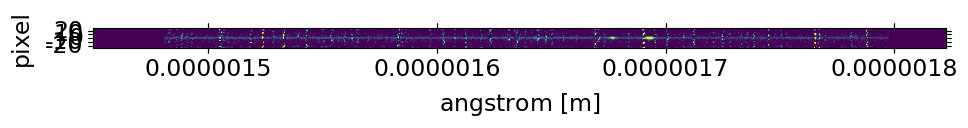

In [74]:
data=mos[0].data
fig =  plt.figure(figsize = (11,1))
ax = plt.subplot(projection = WCS(mos[0].header))
_, med, std = sigma_clipped_stats(data)
norm = vis.ImageNormalize(vmin = med, vmax = med+6*std, stretch = vis.LinearStretch())

ax.imshow(data,norm=norm)

array([   0,    1,    2, ..., 2284, 2285, 2286])

In [5]:
header=mos[0].header

In [6]:
matrix_type='CD'
matrix = [
    [header.get(f'{matrix_type}1_1', 1), header.get(f'{matrix_type}1_2', 0)],
    [header.get(f'{matrix_type}2_1', 0), header.get(f'{matrix_type}2_2', 1)]
]
orientation_angle = np.degrees(np.arctan2(matrix[1][0], matrix[0][0]))
print(f"Orientation angle: {orientation_angle:.2f} degrees")

Orientation angle: 0.00 degrees


In [79]:
from astropy.coordinates import SkyCoord,FK5
#center_ra, center_dec = header["RA"], header["DEC"] 
#Starsc = SkyCoord(ra=center_ra, dec=center_dec, unit='deg',frame=FK5, equinox='J2000')
center_ra, center_dec = 237.98053, 19.15891
slitang=header["SKYPA3"]
length = 20 * u.arcsec
separation = header["NAXIS2"]/2 * header["PSCALE"] * u.arcsec
spec_axis= header["CRVAL1"] + (np.arange(data.shape[1])+1)*header["CD1_1"]

end_point1 = SkyCoord(center_ra, center_dec, frame=FK5, unit='deg', equinox='J2000')\
             .directional_offset_by(slitang, length)

# Compute the start and end points of the second line by offsetting 
# the original points perpendicular to the original direction (i.e., adding 90 degrees to the position angle)
start_point2 = SkyCoord(center_ra, center_dec, frame=FK5, unit='deg', equinox='J2000')\
               .directional_offset_by((slitang+90)*u.deg, separation)

end_point2 = end_point1.directional_offset_by((slitang+90)*u.deg, separation)

start_point3 = SkyCoord(center_ra, center_dec, frame=FK5, unit='deg', equinox='J2000')\
               .directional_offset_by((slitang-90)*u.deg, separation)

end_point3 = end_point1.directional_offset_by((slitang-90)*u.deg, separation)


# Convert to pixel values for both lines
start_pixel1 = spat_wcs.world_to_pixel(SkyCoord(center_ra, center_dec, frame=FK5,unit="deg", equinox='J2000'))
end_pixel1 = spat_wcs.world_to_pixel(end_point1)

start_pixel2 = spat_wcs.world_to_pixel(start_point2)
end_pixel2 = spat_wcs.world_to_pixel(end_point2)

start_pixel3 = spat_wcs.world_to_pixel(start_point3)
end_pixel3 = spat_wcs.world_to_pixel(end_point3)

fig, ax = imshow_astro(slicev, wcsinfo=spat_wcs, cblabel = brighu, vrange = (med, med+10*std))
# Plot the lines
#ax.plot([start_pixel1[0], end_pixel1[0]], [start_pixel1[1], end_pixel1[1]], color='r',ls="--")
ax.plot([start_pixel2[0], end_pixel2[0]], [start_pixel2[1], end_pixel2[1]], color='b',ls="--")
ax.plot([start_pixel3[0], end_pixel3[0]], [start_pixel3[1], end_pixel3[1]], color='b',ls="--")
#ax.plot(start_pixel1[0], end_pixel1[0],"+",c="m",ms=25,lw=0.06)



NameError: name 'CRVAL1' is not defined

In [36]:
print(start_pixel1)
print(end_pixel1)
print(center_ra, center_dec)
sc = SkyCoord(ra=237.98053, dec=19.15891, unit='deg',frame=FK5, equinox='J2000')
s_coord=spat_wcs.world_to_pixel(sc)
print(s_coord)

(array(-4.4276309), array(357.08742606))
(array(243.49214816), array(579.90342233))
237.98512058 19.18480656
(array(47.6), array(46.328))


In [72]:
mos.info()

Filename: /disk/bifrost/yuanze/KBSS/Q1549/BX101/mosfire/Q1549close1_H_BX101_flx.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3457   (2287, 52)   float64   
  1                1 ImageHDU         7   (2287, 52)   float32   


In [66]:
data=mos[0].data
# Generate an array of pixel positions
index = np.arange(data.shape[1])

# Get the spectral values (in the unit specified in the WCS header)
spectral_axis = wcsinfo.all_pix2world(np.column_stack([np.zeros(data.shape[1]), index]), 0)

In [67]:
print(spectral_axis)

[[ 1.45000000e-06 -2.47627461e+01]
 [ 1.45000000e-06 -2.37627461e+01]
 [ 1.45000000e-06 -2.27627461e+01]
 ...
 [ 1.45000000e-06  2.25923725e+03]
 [ 1.45000000e-06  2.26023725e+03]
 [ 1.45000000e-06  2.26123725e+03]]


In [78]:
print(header["PSCALE"]*50)

8.995000000000001
